In [29]:
import matplotlib.pyplot as plt

In [1]:
from typing import Dict

import numpy as np
import torch
import torch.optim as optim
from allennlp.data import DataLoader
from allennlp.data.samplers import BucketBatchSampler
from allennlp.data.vocabulary import Vocabulary
from allennlp.models import Model
from allennlp.modules.seq2vec_encoders import Seq2VecEncoder, PytorchSeq2VecWrapper
from allennlp.modules.text_field_embedders import TextFieldEmbedder, BasicTextFieldEmbedder
from allennlp.modules.token_embedders import Embedding
from allennlp.nn.util import get_text_field_mask
from allennlp.training.metrics import CategoricalAccuracy, F1Measure
from allennlp.common.util import ensure_list

from allennlp_models.classification.dataset_readers.stanford_sentiment_tree_bank import \
    StanfordSentimentTreeBankDatasetReader
from allennlp.data.data_loaders import SimpleDataLoader
from allennlp.training import GradientDescentTrainer



In [2]:
EMBEDDING_DIM = 128
HIDDEN_DIM = 128

In [3]:
# Model in AllenNLP represents a model that is trained.
@Model.register("lstm_classifier")
class LstmClassifier(Model):
    def __init__(self,
                 embedder: TextFieldEmbedder,
                 encoder: Seq2VecEncoder,
                 vocab: Vocabulary,
                 positive_label: str = '4') -> None:
        super().__init__(vocab)
        # We need the embeddings to convert word IDs to their vector representations
        self.embedder = embedder

        self.encoder = encoder

        # After converting a sequence of vectors to a single vector, we feed it into
        # a fully-connected linear layer to reduce the dimension to the total number of labels.
        self.linear = torch.nn.Linear(in_features=encoder.get_output_dim(),
                                      out_features=vocab.get_vocab_size('labels'))

        # Monitor the metrics - we use accuracy, as well as prec, rec, f1 for 4 (very positive)
        positive_index = vocab.get_token_index(positive_label, namespace='labels')
        self.accuracy = CategoricalAccuracy()
        self.f1_measure = F1Measure(positive_index)

        # We use the cross entropy loss because this is a classification task.
        # Note that PyTorch's CrossEntropyLoss combines softmax and log likelihood loss,
        # which makes it unnecessary to add a separate softmax layer.
        self.loss_function = torch.nn.CrossEntropyLoss()

    # Instances are fed to forward after batching.
    # Fields are passed through arguments with the same name.
    def forward(self,
                tokens: Dict[str, torch.Tensor],
                label: torch.Tensor = None) -> torch.Tensor:
        # In deep NLP, when sequences of tensors in different lengths are batched together,
        # shorter sequences get padded with zeros to make them equal length.
        # Masking is the process to ignore extra zeros added by padding
        mask = get_text_field_mask(tokens)

        # Forward pass
        embeddings = self.embedder(tokens)
        encoder_out = self.encoder(embeddings, mask)
        logits = self.linear(encoder_out)

        # In AllenNLP, the output of forward() is a dictionary.
        # Your output dictionary must contain a "loss" key for your model to be trained.
        output = {"logits": logits}
        if label is not None:
            self.accuracy(logits, label)
            self.f1_measure(logits, label)
            output["loss"] = self.loss_function(logits, label)

        return output

    def get_metrics(self, reset: bool = False) -> Dict[str, float]:
        precision, recall, f1_measure = self.f1_measure.get_metric(reset)
        return {'accuracy': self.accuracy.get_metric(reset),
                'precision': precision,
                'recall': recall,
                'f1_measure': f1_measure}

In [4]:
reader = StanfordSentimentTreeBankDatasetReader()

In [5]:
train_dataset = reader.read('https://s3.amazonaws.com/realworldnlpbook/data/stanfordSentimentTreebank/trees/train.txt')
dev_dataset = reader.read('https://s3.amazonaws.com/realworldnlpbook/data/stanfordSentimentTreebank/trees/dev.txt')

In [6]:
train_dataset=ensure_list(train_dataset)
dev_dataset=ensure_list(dev_dataset)

In [7]:
# You can optionally specify the minimum count of tokens/labels.
# `min_count={'tokens':3}` here means that any tokens that appear less than three times
# will be ignored and not included in the vocabulary.
vocab = Vocabulary.from_instances(instances=train_dataset+dev_dataset,
                                  min_count={'tokens': 3})

building vocab:   0%|          | 0/9645 [00:00<?, ?it/s]

In [8]:
train_data_loader = SimpleDataLoader(train_dataset, batch_size=32)
dev_data_loader = SimpleDataLoader(dev_dataset, batch_size=32)

train_data_loader.index_with(vocab)
dev_data_loader.index_with(vocab)

In [20]:
token_embedding = Embedding(num_embeddings=vocab.get_vocab_size('tokens'),
                            embedding_dim=EMBEDDING_DIM).cuda()

In [22]:
# BasicTextFieldEmbedder takes a dict - we need an embedding just for tokens,
# not for labels, which are used as-is as the "answer" of the sentence classification
word_embeddings = BasicTextFieldEmbedder({"tokens": token_embedding}).cuda()

In [23]:
# Seq2VecEncoder is a neural network abstraction that takes a sequence of something
# (usually a sequence of embedded word vectors), processes it, and returns a single
# vector. Oftentimes this is an RNN-based architecture (e.g., LSTM or GRU), but
# AllenNLP also supports CNNs and other simple architectures (for example,
# just averaging over the input vectors).
encoder = PytorchSeq2VecWrapper(
    torch.nn.LSTM(EMBEDDING_DIM, HIDDEN_DIM, batch_first=True)).cuda()

In [24]:
model = LstmClassifier(word_embeddings, encoder, vocab).cuda()

In [25]:
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [26]:
trainer = GradientDescentTrainer(
    model=model,
    optimizer=optimizer,
    data_loader=train_data_loader,
    num_epochs=10,
    gpus=0)

In [27]:
from allennlp.commands.find_learning_rate import *

def _smooth(values: List[float], beta: float) -> List[float]:
    """ Exponential smoothing of values """
    avg_value = 0.0
    smoothed = []
    for i, value in enumerate(values):
        avg_value = beta * avg_value + (1 - beta) * value
        smoothed.append(avg_value / (1 - beta ** (i + 1)))
    return smoothed

  0%|          | 0/100 [00:00<?, ?it/s]

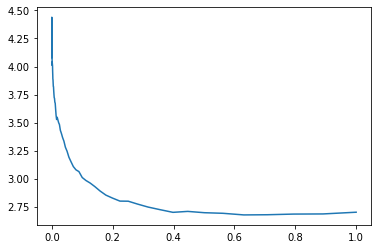

In [30]:

learning_rates, losses = search_learning_rate(trainer,end_lr=1.0)
losses = _smooth(losses, 0.98)
plt.plot(learning_rates, losses)

In [31]:
trainer.train()

  0%|          | 0/267 [00:00<?, ?it/s]

TypeError: must be real number, not str

In [32]:
%debug

> /home/puneet/Envs/venv/lib/python3.8/site-packages/allennlp/training/util.py(429)<listcomp>()
    427         ", ".join(
    428             [
--> 429                 "%s: %.4f" % (name, value)
    430                 for name, value in metrics.items()
    431                 if not name.startswith("_")



ipdb>  name


'precision'


ipdb>  value


'precision'


ipdb>  exit()
